In [293]:
from IPython.display import display, display_html, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Group Assignment
### Team Number: 01
### Team Member Names: Rehan, Rui, Anton
### Team Strategy Chosen: RISKY

*Delete before submission*

IMPORTANT SPECIFICATIONS DURING CODING:

- Stocks must be in US Market

- Stocks must have an average monthly volume of at least 200 000 shares between January 01, 2022 to October 31, 2022.

- Months must have at least 20 trading days

- Must have a minimum of 12 stocks and a maximum of 25 stocks

- If we choose n stocks for our portfolio, each stock must be minimum of (100/(2n))% of the portfolio when weighted by value (i.e., the overall value of the shares purchased in that particular stock) as of closing prices on November 25, 2022

- No individual stock may make up more than 25% of the portfolio when weighted by value (i.e., the overall value of the shares purchased in that particular stock) as of closing prices on November 26, 2022.

- Must spend all 500 000 USD on portfolio

- Teams will purchase their stocks at the closing prices on November 25, 2022

There are more specifications for how our code should be presented before submission, look into the assignment doc for info.

### Global Variables

In [294]:
# Total Investment Size
investment = 500000

# File Name
file = 'Tickers_Example.csv'

# Start date and end date for our portfolio
start_date = '2022-01-01'
end_date = '2022-11-01'


### Extracting/filtering tickers based on assignment specifications and adding them to a list using multithreading for time efficiency

In [295]:
# Initializing a dataframe for 'raw' data extracted from the .csv file
tickers_raw = pd.read_csv(file, header=None)[0].tolist()

# Empty data structures to store ticker data in
tickers = []
tickers_hist = {}

# Function which consumes a ticker and determines the validation based on prerequisites
def validate_ticker(ticker):

    # Extracting ticker info from yFinance
    ticker_info = yf.Ticker(ticker).info

    # Trying every stock and excepting those that throw an error
    try:
        # If the stock is valid, we check for each prerequisite:
        # Checking for USD currency and ensuring it's on the US market
        if ticker_info['currency'] == 'USD' and ticker_info['market'] == 'us_market':
            ticker_hist = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d').dropna()

            # Checking monthly volume
            ticker_monthly_trading_days = ticker_hist['Volume'].groupby(pd.Grouper(freq='MS')).count()
            ticker_monthly_volume = ticker_hist['Volume'].groupby(pd.Grouper(freq='MS')).sum()

            # Checking if the month has at least 20 trading days
            for month in ticker_monthly_trading_days.index:
                if ticker_monthly_trading_days.loc[month] < 20:
                    ticker_monthly_volume.drop(month, inplace=True)

            # Checking if the average monthly volume is greater than or equal to 200,000 USD
            if ticker_monthly_volume.mean() >= 200000:
                tickers.append(ticker)
                tickers_hist[ticker] = ticker_hist
            else:
                print(f'{ticker} Ticker does not meet average monthly volume requirements')
        else:
            print(f'{ticker} Ticker does not reference stock denominated in USD')
    except:
        print(f'Error: {ticker} Ticker does not reference a valid stock')

# Empty data structure for threading
threads = []

# Checking validity of each ticker in list of tickers given from threading
for ticker in tickers_raw:
    thread = Thread(target=validate_ticker, args=[ticker])
    thread.start()
    threads.append(thread)

# Using threading
for thread in threads:
    thread.join()

TD.TO Ticker does not reference stock denominated in USD
Error: TWX Ticker does not reference a valid stock
RY.TO Ticker does not reference stock denominated in USD
Error: RTN Ticker does not reference a valid stock
Error: CELG Ticker does not reference a valid stock
Error: AGN Ticker does not reference a valid stock
Error: PCLN Ticker does not reference a valid stock


### List of Valid Tickers

In [296]:
print(tickers)

['MON', 'BIIB', 'CSCO', 'AIG', 'SBUX', 'COF', 'COST', 'ORCL', 'LLY', 'GOOG', 'PYPL', 'MSFT', 'OXY', 'GM', 'C', 'KMI', 'T', 'MRK', 'SPG', 'KO', 'MO', 'SLB', 'NEE', 'MS', 'AXP', 'QCOM', 'ABBV', 'PM', 'ABT', 'PEP', 'BMY', 'PG', 'USB', 'COP', 'JPM', 'AMZN', 'TGT', 'BLK', 'AAPL', 'ACN', 'PFE', 'BAC', 'CL', 'UPS', 'UNP', 'NKE', 'BK', 'BA', 'SO', 'CVS', 'UNH', 'TXN', 'CMCSA', 'CAT', 'LMT']


---

## Strategy and Data Analytics

The strategy our team has chosen is to go risky, meaning we must optimize a portfolio so that it is driven away as much as possible, from the initial starting value of $500,000. Since we are pursuing a risky strategy, there are a few factors to an optimal portfolio.

Since we want the most risk and most reward, we want to minimize any diversification involved. Essentially, out of the minimum and maximum requirements for stock diversification, we want to pick the least amount of stocks, which is a minimum of 12 and keep diversification at an all time low. Furthermore, our stocks can net heavy volume, however, volume is useless if the market direction for these assets is all over the place. Therefore, we need all of our stocks to move in the same direction. 

Overall, we will move forward with the minimum amount of stocks involved, 12, and keep track of various factors like each stocks' weightings, risk to reward ratio, positive risk, negative risk, betas and options markets.

### Measuring Beta

Beta calculates the volatility of a stock given the covariance of the stock relative to the broader stock market and the variance of the stock. We can use this to our advantage and find the higher volatility stocks so that we can create a riskier portfolio. The formula for Beta is as follows:

$$
\beta_i = \frac {\mathrm{Cov} (r_i,r_m)}{\mathrm{Var} (r_m)}
$$


Where $ \beta_i $ is the market beta of a stock, $ {\mathrm{Cov} (r_i,r_m)} $ is the covariance between the stock and the market index (in our case, the S&P 500), $ {\mathrm{Var} (r_m)} $ is the variance of the market index. Since a volatile stock can net us a gain or a loss, we want the highest magnitude. Thus, we will be using Beta as a measure to quantify the portfolios we will be creating later so that we can rank them and subsequently, choose the greatest magnitude.

In [297]:
min_stocks = 12
max_stocks = 25

# Using the S&P 500 as our market index (the ticker is "^GSPC")
market_index = yf.Ticker('^GSPC').history(start=start_date, end=end_date, interval='1d').dropna()['Close']
market_return = market_index.pct_change()
market_variance = market_return.var()

# Dictionary to store the beta of every ticker
beta_dict = {}

# Calculating beta
for ticker in tickers:
    stock_return = tickers_hist[ticker]['Close'].pct_change()
    covariance = pd.DataFrame({ticker: stock_return, 'S&P 500': market_return}).cov().loc[ticker, 'S&P 500']
    beta_dict[ticker] = covariance / market_variance

# Storing all betas in a dataframe
beta_df = pd.DataFrame(beta_dict.items(), columns=['Ticker', 'Beta'])
beta_df.sort_values(by=['Beta'], ascending=False, ignore_index=True, inplace=True)

# Initializing a dictionary to store each portfolios' average betas for comparison purposes later
final_betas = {}

---

### Optimal Weighting for Stocks

Since we want the highest volatility possible, we want to invest the majority of our funds into the most volatile stock before investing into the others. Given the requirements of a stock only being a maximum of 25% of the entire portfolio or a minimum of 100/2n where n is the number of stocks we have chosen (in our case, 12), we have calculated an optimal weighting below to create the most volatility.

In [298]:
min_weighting = 100 / (min_stocks * 2)
max_weighting = 25
total_weighting = 0 
min_stocks

# This list will have the weightings of our 12 prospective stocks
list_of_weighting = []

# This program puts the majority of the weighting at the beginning of the list (so that the more volatile stocks can take them up first)
while (min_stocks != 0):
    temp_weighting = min_weighting * (min_stocks - 1)
    remaining_weight = 100 - (temp_weighting + total_weighting)
    
    if (remaining_weight > max_weighting):
        list_of_weighting.append(max_weighting/100)
        total_weighting += max_weighting
    elif (remaining_weight > min_weighting):
        list_of_weighting.append(remaining_weight/100)
        total_weighting += remaining_weight
    else:
        list_of_weighting.append(min_weighting/100)
        total_weighting += min_weighting
    min_stocks -= 1

Here is the list of weightings:

In [299]:
print (list_of_weighting)

[0.25, 0.25, 0.125, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667, 0.04166666666666667]


---

#### Below is the function that calculates the number of shares we will invest in each stock ####

In [300]:
# This function calculates the number of stocks to invest in given a list of 12 stocks
def num_stocks (tickers_list):
    
    # Calculating the $ amount to invest into each stock 
    investment_list = []
    for i in range(len(list_of_weighting)):
        investment_list.append((list_of_weighting[i] * investment))
        
    # Getting the number of stocks invested in each ticker
    stocks_in_each = []
    price_of_each = []
    for i in range(len(tickers_list)):
        stocks_in_each.append (investment_list[i] / tickers_hist.get(tickers_list[i])['Close'][0])
        price_of_each.append(tickers_hist.get(tickers_list[i])['Close'][0])

    frame = {"Ticker": tickers_list,
             "Price": price_of_each,
             "Shares": stocks_in_each,
             "Value": investment_list,
             "Weight": list_of_weighting}
    
    stocks_dataframe = pd.DataFrame(frame)

    return (stocks_dataframe)

portfolio_candidates = {} #This variable stores each strategy's portfolios to export into a .csv file later on

---

#### Below is the function that will generate our portfolios ####
We will also be defining a function that can generate our portfolio over a period of time so that we can visually see how each portfolio performs relative to each other.

In [301]:
# generate_portfolio takes in a ticker and tracks how the ticker does over a time period
def generate_portfolio(ticker, num_stocks):
    
    # Finding the number of trading days for the stock
    ticker_hist = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d').dropna() 
    days_trading = len(ticker_hist.index)
        
    
    # Calculating how the stock performs over this time period
    values = []
    for i in range(days_trading):
        value = tickers_hist.get(ticker)['Close'][i] * num_stocks
        values.append(value)
         
    return values
    
# generate_combined_portfolio takes in a dataframe (index, "Ticker", "Stock", "Investment") and generates the portfolio over the time period
# This is the function that we will be calling
def generate_combined_portfolio(dataframe):
    final_df = pd.DataFrame()
    values_list = []
    ticker_list = []

    for i in range(len(dataframe.index)):
        ticker = dataframe['Ticker'][i]
        ticker_list.append(ticker)
        values_list.append(generate_portfolio(ticker, dataframe['Shares'][i]))

    for i in range(len(dataframe.index)):
        frame = {ticker_list[i]: values_list[i]}
        final_df[ticker_list[i]] = pd.DataFrame(frame)

    final_df = final_df.set_index(tickers_hist.get(dataframe['Ticker'][0]).index)
    final_df['Total Value'] = final_df.sum(axis=1)
    
    return final_df

Now that we have finished setting up our quantifiers and portfolio generators, we can move on to the strategies we will be implementing to yield a portfolio with the highest volatility.

---

### Correlation ###
Since we want the stocks to move in the same general direction, we will need to compare their movements relative to the market index. Thus, we will be using the __Correlation Coefficient__ to determine which stocks are the most correlated to S&P500. Since a stock could be directly correlated or inversely correlated (though very unlikely), we will be accounting for an upper bound of and a lower bound (so we will have a list of 12 stocks that are the most correlated and 12 stocks that are the most inversely correlated). Afterwards, we can obtain the mean beta of each list and yield the highest magnitude as a contender for our final portfolio.

The formula for correlation is given by: 
\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}
Where, for our purposes, $ COR(X,Y) $ is the correlation between a stock and the market index, $ {\sigma_X } $ is the deviation of the stock and $ { \sigma_Y } $ is the deviation of the market index.


In [302]:

# Setting up correlation dictionary for all tickers
corr_dict = {}

# Calculating correlation
for ticker in tickers:
    stock_return = tickers_hist[ticker]['Close'].pct_change()
    corr = pd.DataFrame({ticker: stock_return, 'S&P 500': market_return}).corr().loc[ticker, 'S&P 500']
    corr_dict[ticker] = corr

# Creating correlation dataframe for all tickers
corr_df = pd.DataFrame(corr_dict.items(), columns=['Ticker', 'Correlation'])
corr_df.sort_values(by=['Correlation'], ascending=False, ignore_index=True, inplace=True)


Below are the tickers with the highest correlation:

In [303]:
corr_df.head(12)

,Ticker,Correlation
0,ACN,0.892554
1,AAPL,0.882333
2,MSFT,0.866140
3,BLK,0.861315
4,GOOG,0.829202
5,TXN,0.804366
6,NKE,0.780587
7,MS,0.776555
8,AMZN,0.774818
9,QCOM,0.766427


Below are the tickers with the lowest correlation:

In [304]:
corr_df.tail(12)

,Ticker,Correlation
43,BIIB,0.432732
44,T,0.421944
45,BMY,0.386757
46,MRK,0.377811
47,PM,0.375340
48,COP,0.371408
49,ABBV,0.347691
50,MO,0.328813
51,SLB,0.311781
52,OXY,0.300052


In [305]:
corr_high_mean = corr_df.head(12)['Correlation'].mean()
corr_low_mean = corr_df.tail(12)['Correlation'].mean()

# Getting the list with a higher correlation on average
if (corr_high_mean > corr_low_mean):
    corr_tickers = list(corr_df.head(12)['Ticker'])
else:
    corr_tickers = list(corr_df.tail(12)['Ticker'])

Here is the list of tickers we will be using for the correlation portfolio:

In [306]:
print(corr_tickers)

['ACN', 'AAPL', 'MSFT', 'BLK', 'GOOG', 'TXN', 'NKE', 'MS', 'AMZN', 'QCOM', 'AXP', 'GM']


In [307]:
# Getting the beta of each stock from our correlation tickers and sorting them from highest to lowest
corr_df = pd.DataFrame(corr_tickers, columns = ['Ticker'])
corr_df['Beta'] = corr_df['Ticker'].replace(beta_dict)

corr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)
corr_tickers = list(corr_df['Ticker']) # reorganizing the list so that the highest betas come first
corr_beta = corr_df['Beta'].mean()
final_betas['Correlation'] = corr_beta

Here is the tickers' and their respective betas:

In [308]:
display(corr_df)

,Ticker,Beta
0,AMZN,1.604552
1,QCOM,1.454487
2,GM,1.393548
3,GOOG,1.310727
4,NKE,1.300717
5,BLK,1.269739
6,AAPL,1.265965
7,MSFT,1.247844
8,ACN,1.164351
9,AXP,1.141406


The corresponding weighting and investment amount into each stock is:

In [309]:
corr_df = num_stocks(corr_tickers)
portfolio_candidates["Correlation"] = corr_df
display(corr_df)

,Ticker,Price,Shares,Value,Weight
0,AMZN,170.404495,733.548724,125000.000000,0.250000
1,QCOM,186.210007,671.285084,125000.000000,0.250000
2,GM,61.169998,1021.742715,62500.000000,0.125000
3,GOOG,145.074493,143.604385,20833.333333,0.041667
4,NKE,164.669998,126.515659,20833.333333,0.041667
5,BLK,911.729980,22.850333,20833.333333,0.041667
6,AAPL,182.009995,114.462579,20833.333333,0.041667
7,MSFT,334.750000,62.235499,20833.333333,0.041667
8,ACN,406.156982,51.293796,20833.333333,0.041667
9,AXP,167.788895,124.163958,20833.333333,0.041667


The resulting portfolio is:

In [310]:
corr_portfolio = generate_combined_portfolio(corr_df)
display(corr_portfolio)

,AMZN,QCOM,GM,GOOG,NKE,BLK,AAPL,MSFT,ACN,AXP,TXN,MS,Total Value
Date,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,125000.000000,125000.000000,62500.000000,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,20833.333333,500000.000000
2022-01-04 00:00:00-05:00,122885.551624,125684.703411,67169.363895,20738.843156,21050.940421,20958.781436,20568.925056,20476.102176,20684.454844,21502.139343,20855.193790,21679.641547,504254.640699
2022-01-05 00:00:00-05:00,120563.863646,125194.668167,64104.139648,19767.646633,20527.165670,20377.241586,20021.794069,19690.067518,20320.187182,21273.009323,20420.164540,21143.160120,493403.108103
2022-01-06 00:00:00-05:00,119754.761731,124825.459323,64236.963395,19752.925957,20374.080873,20462.244154,19687.563549,19534.478770,19338.916267,21467.947647,20413.604902,21504.972692,491353.919261
2022-01-07 00:00:00-05:00,119241.279863,121106.544464,63623.919325,19674.447090,19859.163145,20388.666753,19707.021977,19544.436678,18967.998945,21651.711670,19613.500863,21635.973934,485014.664708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 00:00:00-04:00,88465.974962,79997.042232,37814.696164,15068.408110,11604.016397,14531.440596,17437.228831,15599.950440,14393.551298,18254.585692,17724.728759,16857.770583,347749.394063
2022-10-26 00:00:00-04:00,84842.248073,79285.481682,38683.179810,13616.567695,11688.781656,14573.941880,17094.986838,14396.316114,14355.594390,18237.202814,17255.813884,16941.525815,340971.640651
2022-10-27 00:00:00-04:00,81394.565713,76996.397087,38989.701845,13297.765786,11454.727880,14829.408432,16574.181755,14111.899427,14302.761843,18248.377116,17134.486434,16895.460357,334229.733676


Thus our correlation portfolio has been created and we will be moving on to the other portfolio types

---

## Add K-MST Algorithm stuff here

---

## Options Market

Another factor to look into is the options market. Although the options market doesn't directly tell us how a stock is performing, the option traders may give us a hint as to where the stock is heading in a short period of time. If the ratio of puts to calls is high, the stock price is predicted to most likely drop. On the contrary, if the ratio of calls to puts is high, the stock price is predicted to most likely jump.

### Put to Call Ratio ###
- Divide sum of puts by sum of calls
- More calls than puts means the asset price will increase (as investors want to buy the asset at a predetermined price) --> they are expecting the price to increase
- More puts than calls means the asset price will decrease (as investors want to sell the asset at a predetermined price) --> they are expecting the price to fall

### Checking if the options market is large enough for the chosen stocks:

In [311]:
# Global variables to check for availability of options, put-to-call ratios and call-to-put ratios
options_large_enough = False
pcr_large_enough = False
cpr_large_enough = False

In [312]:
options_evaluation_raw = {}
options_evaluation_raw['puts_sum'] = {}
options_evaluation_raw['calls_sum'] = {}
options_evaluation_raw['pcr'] = {}
options_evaluation_raw['cpr'] = {}

def extract_options_market(ticker):

    try:
        asset = yf.Ticker(ticker)
        options = asset.option_chain(asset.options[0])

        puts = pd.DataFrame().append(options.puts)
        puts_sum = puts['volume'].sum()
        options_evaluation_raw["puts_sum"][ticker] = puts_sum

        calls = pd.DataFrame().append(options.calls)
        calls_sum = calls['volume'].sum()
        options_evaluation_raw["calls_sum"][ticker] = calls_sum

        puts_to_calls =  puts_sum / calls_sum
        options_evaluation_raw["pcr"][ticker] = puts_to_calls

        calls_to_puts =  calls_sum / puts_sum
        options_evaluation_raw["cpr"][ticker] = calls_to_puts
    
    except IndexError as error:
        print(f'Dropped {ticker}, no options data available')
    
# Checking options market of each ticker in list of tickers given from threading
for ticker in tickers:
    thread = Thread(target=extract_options_market, args=[ticker])
    thread.start()
    threads.append(thread)

# Using threading
for thread in threads:
    thread.join()        


Dropped MON, no options data available


In [313]:
if len(options_evaluation_raw.keys()) <= 12:
    options_large_enough = True
    options_evaluation = pd.DataFrame(options_evaluation_raw)
    print("The options market was large enough for at least 12 stocks. Here is the summary:")
    display(options_evaluation.head())
else:
    print("There was insufficient options data for the tickers provided.")

The options market was large enough for at least 12 stocks. Here is the summary:


,puts_sum,calls_sum,pcr,cpr
BK,12.0,21.0,0.571429,1.750000
NEE,174.0,558.0,0.311828,3.206897
PM,60.0,275.0,0.218182,4.583333
MO,567.0,228.0,2.486842,0.402116
KMI,665.0,1106.0,0.601266,1.663158


Let's filter for any stocks with a put-to-call ratio which is below one, and filter for any stocks with a call-to-put ratio which is below one separately. We want our portfolio to move large in one direction, so we must account for stocks which may offset any gains and losses from other stocks. Thus, we will create a portfolio strictly consisting of heavy put-to-call ratio stocks and another portfolio strictly consisting of heavy call-to-put ratio stocks for further comparison. If only one portfolio can be formed, then the comparison step will be skipped.

In [314]:
if options_large_enough:
    # Filtering for stocks with a puts-to-calls ratio greater than 1 and sorting
    pcr_filter = pd.DataFrame()
    pcr_filter = options_evaluation[options_evaluation["pcr"] > 1].dropna()
    pcr_filter = pcr_filter.sort_values(by=['pcr'], ascending=False)
    print("Displaying the puts-to-calls ratios for the stocks:")
    display(pcr_filter.head())
else:
    print("The options market had insufficient data, skipping...")

Displaying the puts-to-calls ratios for the stocks:


,puts_sum,calls_sum,pcr,cpr
SLB,2559.0,317.0,8.072555,0.123877
TXN,1601.0,222.0,7.211712,0.138663
AAPL,57121.0,11785.0,4.846924,0.206316
PYPL,2935.0,655.0,4.480916,0.223169
AXP,778.0,180.0,4.322222,0.231362


Forming the portfolio for the heavy put-to-call ratio stocks,

In [315]:
# Checking if there are enough heavy puts-to-calls ratio stocks
if options_large_enough and len(pcr_filter) >= 12:
    print("There are at least 12 stocks with a heavy puts-to-calls ratio.")
    pcr_large_enough = True
    pcr_heavy_tickers = []
    pcr_heavy_tickers = list(pcr_filter.index.values)
    # Removing everything after the first 12 tickers
    pcr_heavy_tickers = pcr_heavy_tickers[0:12]
    print(pcr_heavy_tickers)
else: 
    print("There are not enough stocks with a puts-to-calls ratio greater than 1.")


There are at least 12 stocks with a heavy puts-to-calls ratio.
['SLB', 'TXN', 'AAPL', 'PYPL', 'AXP', 'USB', 'UNP', 'NKE', 'CAT', 'MO', 'SPG', 'BMY']


In [316]:
if options_large_enough:
    # Filtering for stocks with a calls-to-puts ratio greater than 1
    cpr_filter = pd.DataFrame()
    cpr_filter = options_evaluation[options_evaluation["cpr"] > 1].dropna()
    cpr_filter = cpr_filter.sort_values(by=['cpr'], ascending=False)
    print("Displaying the calls-to-puts ratios for the stocks:")
    display(cpr_filter.head())
else:
    print("The options market had insufficient data, skipping...")

Displaying the calls-to-puts ratios for the stocks:


,puts_sum,calls_sum,pcr,cpr
AIG,193.0,4247.0,0.045444,22.005181
MS,3945.0,24982.0,0.157914,6.332573
PM,60.0,275.0,0.218182,4.583333
SBUX,182.0,778.0,0.233933,4.274725
PFE,1440.0,6050.0,0.238017,4.201389


In [317]:
# Checking if there are enough heavy calls-to-puts ratio stocks
if options_large_enough and len(cpr_filter) >= 12:
    print("There are at least 12 stocks with a heavy calls-to-puts ratio.")
    cpr_large_enough = True
    cpr_heavy_tickers = []
    cpr_heavy_tickers = list(cpr_filter.index.values)
    # Removing everything after the first 12 tickers
    cpr_heavy_tickers = cpr_heavy_tickers[0:12]
    print(cpr_heavy_tickers)
else: 
    print("There are not enough stocks with a calls-to-puts ratio greater than 1.")


There are at least 12 stocks with a heavy calls-to-puts ratio.
['AIG', 'MS', 'PM', 'SBUX', 'PFE', 'SO', 'COF', 'OXY', 'NEE', 'C', 'BAC', 'UPS']


### Calculating betas for the portfolios with heavy calls-to-puts ratios and heavy puts-to-calls ratios

In [318]:
if cpr_large_enough:
    # Getting the call-to-put ratio portfolios' betas
    cpr_df = pd.DataFrame(cpr_heavy_tickers, columns = ['Ticker'])
    cpr_df['Beta'] = cpr_df['Ticker'].replace(beta_dict)

    cpr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)
    display(cpr_df)
else:
    print("The call-to-put ratio was not available for enough stocks.")

,Ticker,Beta
0,COF,1.247706
1,SBUX,1.107557
2,MS,1.052367
3,AIG,1.008040
4,BAC,0.991630
5,C,0.949343
6,UPS,0.850226
7,NEE,0.744378
8,OXY,0.703407
9,PFE,0.528784


In [319]:
if pcr_large_enough:
    # Getting the put-to-call ratio portfolios' betas
    pcr_df = pd.DataFrame(pcr_heavy_tickers, columns = ['Ticker'])
    pcr_df['Beta'] = pcr_df['Ticker'].replace(beta_dict)

    pcr_df.sort_values(by = ['Beta'], ascending=False, ignore_index = True, inplace = True)

    display(pcr_df)
else:
    print("The put-to-call ratio was not available for enough stocks.")

,Ticker,Beta
0,PYPL,1.651318
1,NKE,1.300717
2,AAPL,1.265965
3,AXP,1.141406
4,TXN,1.056569
5,SPG,0.989628
6,CAT,0.793218
7,USB,0.767797
8,UNP,0.663091
9,SLB,0.661120


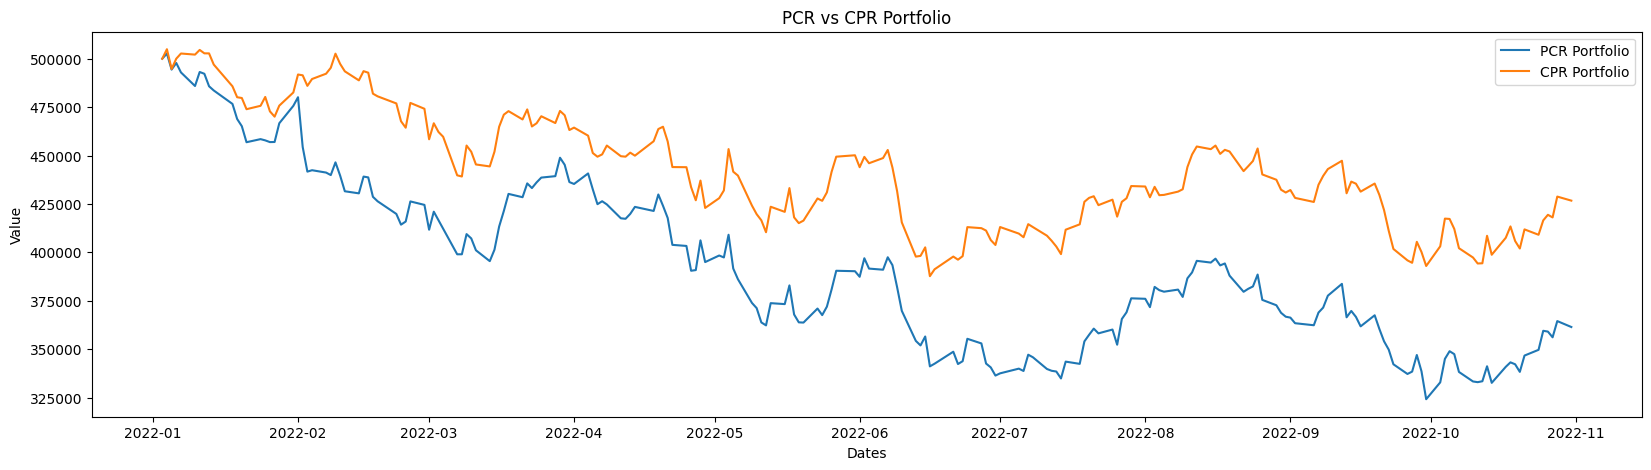

In [320]:
if (cpr_large_enough and pcr_large_enough):
    # Generating portfolios for PCR and CPR stocks
    pcr_list = pcr_df['Ticker'].tolist()
    pcr_candidate = num_stocks(pcr_list)
    pcr_portfolio = generate_combined_portfolio(pcr_candidate)
    cpr_list = cpr_df['Ticker'].tolist()
    cpr_portfolio = generate_combined_portfolio(num_stocks(cpr_list))

    # Graphing the portfolios
    plt.figure(figsize=(20, 5))
    plt.plot(pcr_portfolio.index, pcr_portfolio['Total Value'], label='PCR Portfolio')
    plt.plot(cpr_portfolio.index, cpr_portfolio['Total Value'], label='CPR Portfolio')

    plt.title('PCR vs CPR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()

elif(cpr_large_enough):
    # Generating protfolio for CPR stocks
    cpr_list = cpr_df['Ticker'].tolist()
    cpr_candidate = num_stocks(cpr_list)
    cpr_portfolio = generate_combined_portfolio(cpr_candidate)

    # Graphing the portfolio
    plt.figure(figsize=(20, 5))
    plt.plot(cpr_portfolio.index, cpr_portfolio['Total Value'], label='CPR Portfolio')

    plt.title('CPR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()

elif(pcr_large_enough):
    # Gererating portfolios for PCR stocks
    pcr_list = pcr_df['Ticker'].tolist()
    pcr_portfolio = generate_combined_portfolio(num_stocks(pcr_list))

    # Graphing the portfolios
    plt.figure(figsize=(20, 5))
    plt.plot(pcr_portfolio.index, pcr_portfolio['Total Value'], label='PCR Portfolio')

    plt.title('PCR Portfolio')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()
else:
    print ("None of the options markets were large enough.")


### Comparing puts-to-calls and calls-to-puts portfolios and their Betas ###
The above should graph the puts-to-calls and calls-to-puts portfolios. In the case that only one of them is available, it will only print the available one. If none are available, then we will skip this part of the data analytics.

#### Analysis ####
In the case that both the calls-to-puts and puts-to-calls portfolios are available (and graphed), then we can compare the magnitude of the difference between their starting point and ending point. The portfolio with the greater different in magnitude should also correspond to having a __higher__ beta value. 

In [321]:
use_cpr = False
use_pcr = False
if (cpr_large_enough and pcr_large_enough):
    cpr_beta_mean = cpr_df['Beta'].mean()
    pcr_beta_mean = pcr_df['Beta'].mean()
elif (cpr_large_enough):
    cpr_beta_mean = cpr_df['Beta'].mean()
    print("The only options market available is the calls-to-puts ratio and the overall beta is: " + str(cpr_beta_mean))
elif (pcr_large_enough):
    pcr_beta_mean = pcr_df['Beta'].mean()
    print("The only options market available is the puts-to-calls ratio and the overall beta is: " + str(pcr_beta_mean))
else:
    print("None of the options markets were large enough, thus the options market will have no influence over our final portfolio")
    
if (cpr_large_enough and pcr_large_enough):
    if (cpr_beta_mean > pcr_beta_mean):
        options_portfolio = cpr_portfolio
        use_cpr = True
        options_beta = cpr_beta_mean
        final_betas['Options'] = options_beta
        portfolio_candidates["Options"] = cpr_candidate
        print("The greater beta comes from the calls-to-puts ratio and the overall beta of it is: " + str(cpr_beta_mean))
        print("Thus, our options portfolio will be based on the calls-to-puts ratio")
    elif (cpr_beta_mean < pcr_beta_mean):
        options_portfolio = pcr_portfolio
        use_pcr = True
        options_beta = pcr_beta_mean
        final_betas['Options'] = options_beta
        portfolio_candidates["Options"] = pcr_candidate
        print("The greater beta comes from the puts-to-calls ratio and the overall beta of it is: " + str(pcr_beta_mean))
        print("Thus, our options portfolio will be based on the puts-to-calls ratio")
        

The greater beta comes from the puts-to-calls ratio and the overall beta of it is: 0.9141097833039048
Thus, our options portfolio will be based on the puts-to-calls ratio


---

### Comparing the different strategies ###

Now that we have all of our portfolios, we can graph and quantify them by their magnitudes of beta to determine which portfolio we will use as our final.

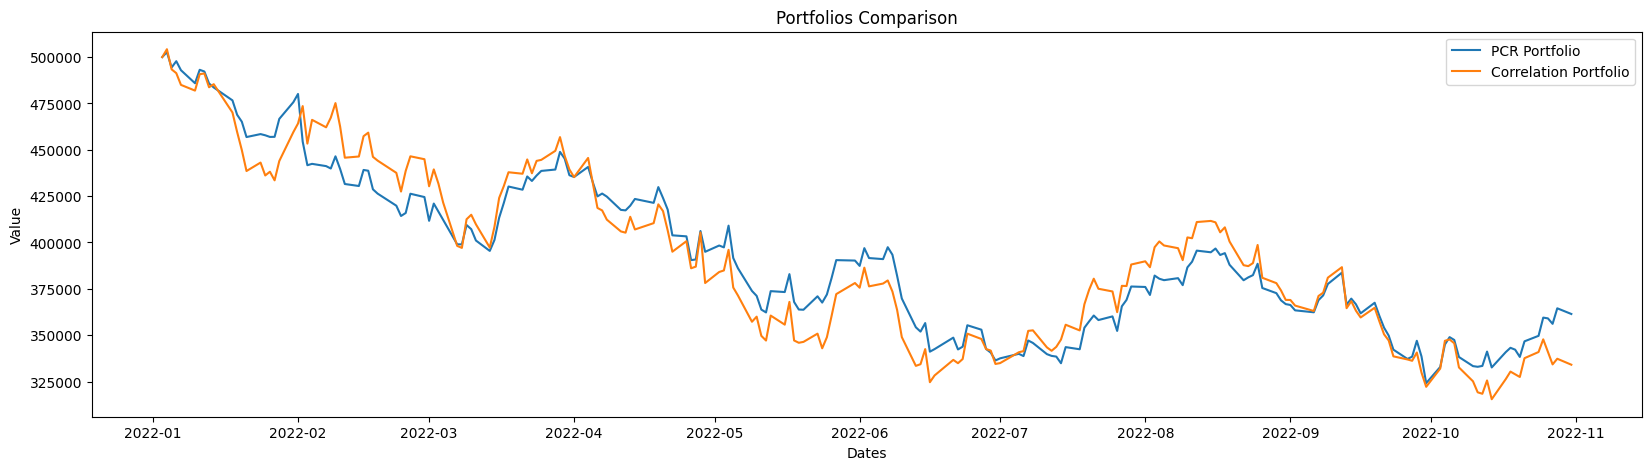

In [322]:
# Graphing the portfolios:
if (pcr_large_enough and cpr_large_enough):
    if (use_pcr):
        plt.figure(figsize=(20, 5))
        plt.plot(options_portfolio.index, options_portfolio['Total Value'], label='PCR Portfolio')
        plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
        #plot k-MST algorithm portfolio here

        plt.title('Portfolios Comparison')
        plt.xlabel('Dates')
        plt.ylabel('Value')

        plt.legend()
        plt.show()
    elif (use_cpr):
        plt.figure(figsize=(20, 5))
        plt.plot(options_portfolio.index, options_portfolio['Total Value'], label='CPR Portfolio')
        plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
        #plot k-MST algorithm portfolio here

        plt.title('Portfolios Comparison')
        plt.xlabel('Dates')
        plt.ylabel('Value')

        plt.legend()
        plt.show()
else:
    plt.figure(figsize=(20, 5))
    plt.plot(corr_portfolio.index, corr_portfolio['Total Value'], label='Correlation Portfolio')
    #plot k-MST algorithm portfolio here

    plt.title('Portfolios Comparison')
    plt.xlabel('Dates')
    plt.ylabel('Value')

    plt.legend()
    plt.show()


The above graph shows how each portfolio performs over a 1 year time period. The portfolio that ends the furthest away from the starting investment of 500 000 USD should also correspond to having a greater magnitude of beta.

In [323]:
if (use_cpr or use_pcr):
    print ("The options portfolio's average beta is: " + str(options_beta))
print ("The correlation portfolio's average beta is: " + str(corr_beta))
print ("The k-MST algorithm portfolio's average beta is: ") #add k-MST average beta here

The options portfolio's average beta is: 0.9141097833039048
The correlation portfolio's average beta is: 1.2718561700305029
The k-MST algorithm portfolio's average beta is: 


In [324]:
max_beta = max(final_betas, key=final_betas.get)
print("The max beta value we got is from the " + max_beta + " portfolio")

The max beta value we got is from the Correlation portfolio


#### Creating the "Portfolio_Final" as required by assignment specifications ####

In [325]:
Portfolio_Final = portfolio_candidates.get(max_beta)
display(Portfolio_Final)

,Ticker,Price,Shares,Value,Weight
0,AMZN,170.404495,733.548724,125000.000000,0.250000
1,QCOM,186.210007,671.285084,125000.000000,0.250000
2,GM,61.169998,1021.742715,62500.000000,0.125000
3,GOOG,145.074493,143.604385,20833.333333,0.041667
4,NKE,164.669998,126.515659,20833.333333,0.041667
5,BLK,911.729980,22.850333,20833.333333,0.041667
6,AAPL,182.009995,114.462579,20833.333333,0.041667
7,MSFT,334.750000,62.235499,20833.333333,0.041667
8,ACN,406.156982,51.293796,20833.333333,0.041667
9,AXP,167.788895,124.163958,20833.333333,0.041667


Confirming that the value adds up to 500 000 and that the weight adds up to 1 (which is 100%)

In [326]:
print ("The total value of the portfolio is: " + str(Portfolio_Final['Value'].sum()))
print ("The total weight of the portfolio is: " + str(Portfolio_Final['Weight'].sum()))

The total value of the portfolio is: 500000.0
The total weight of the portfolio is: 1.0


#### Creating "Stocks_Final" to export into a .csv file ####

In [327]:
Stocks_Final = pd.DataFrame()
Stocks_Final['Ticker'] = Portfolio_Final['Ticker']
Stocks_Final['Shares'] = Portfolio_Final['Shares']

In [328]:
Stocks_Final.to_csv('Stocks_Group_01.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Rui, Rehan, Anton